## Import Libraries

In [2]:
import sys
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import tensorflow as tf
from tensorflow import keras


print('Python: {}'.format(sys.version))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))
print('Sklearn: {}'.format(sklearn.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Keras: {}'.format(keras.__version__))

Python: 3.8.18 (default, Sep 11 2023, 13:39:12) [MSC v.1916 64 bit (AMD64)]
Pandas: 2.0.3
Numpy: 1.24.4
Sklearn: 1.3.2
Matplotlib: 3.7.4
Keras: 2.10.0


In [3]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

In [4]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import joblib

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.optimizers import Adam

### Data Cleaning

In [5]:
df = pd.read_csv("heart.csv")

In [6]:
df.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

In [7]:
df.shape

(918, 12)

In [8]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [10]:
df = df.dropna(axis=0)
df.shape

(918, 12)

In [11]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

#### Converting categorical vars to numerical

In [12]:
df['Sex'].replace({'M':1, 'F':0}, inplace=True)

In [13]:
df['ChestPainType'].unique()

array(['ATA', 'NAP', 'ASY', 'TA'], dtype=object)

In [14]:
df['ChestPainType'].replace({'TA':0, 'ATA':1, 'NAP':2, 'ASY':3}, inplace=True)

In [15]:
df['RestingECG'].unique()

array(['Normal', 'ST', 'LVH'], dtype=object)

In [16]:
df['RestingECG'].replace({'Normal':0, 'ST':1, 'LVH':2}, inplace=True)

In [17]:
df['ExerciseAngina'].unique()

array(['N', 'Y'], dtype=object)

In [18]:
df['ExerciseAngina'].replace({'Y':1, 'N':0}, inplace=True)

In [19]:
df['ST_Slope'].unique()

array(['Up', 'Flat', 'Down'], dtype=object)

In [20]:
df['ST_Slope'].replace({'Up':0, 'Flat':1, 'Down':2}, inplace=True)

In [21]:
df.dtypes

Age                 int64
Sex                 int64
ChestPainType       int64
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG          int64
MaxHR               int64
ExerciseAngina      int64
Oldpeak           float64
ST_Slope            int64
HeartDisease        int64
dtype: object

In [22]:
df.describe()

Age         Sex  ChestPainType   RestingBP  Cholesterol  \
count  918.000000  918.000000     918.000000  918.000000   918.000000   
mean    53.510893    0.789760       2.251634  132.396514   198.799564   
std      9.432617    0.407701       0.931031   18.514154   109.384145   
min     28.000000    0.000000       0.000000    0.000000     0.000000   
25%     47.000000    1.000000       2.000000  120.000000   173.250000   
50%     54.000000    1.000000       3.000000  130.000000   223.000000   
75%     60.000000    1.000000       3.000000  140.000000   267.000000   
max     77.000000    1.000000       3.000000  200.000000   603.000000   

        FastingBS  RestingECG       MaxHR  ExerciseAngina     Oldpeak  \
count  918.000000  918.000000  918.000000      918.000000  918.000000   
mean     0.233115    0.603486  136.809368        0.404139    0.887364   
std      0.423046    0.805968   25.460334        0.490992    1.066570   
min      0.000000    0.000000   60.000000        0.000000   -2.600000   
25%      0.000000    0.000000  120.000000        0.000000    0.000000   
50%      0.000000    0.000000  138.000000        0.000000    0.600000   
75%      0.000000    1.000000  156.000000        1.000000    1.500000   
max      1.000000    2.000000  202.000000        1.000000    6.200000   

         ST_Slope  HeartDisease  
count  918.000000    918.000000  
mean     0.638344      0.553377  
std      0.607056      0.497414  
min      0.000000      0.000000  
25%      0.000000      0.000000  
50%      1.000000      1.000000  
75%      1.000000      1.000000  
max      2.000000      1.000000

### Data Visualization

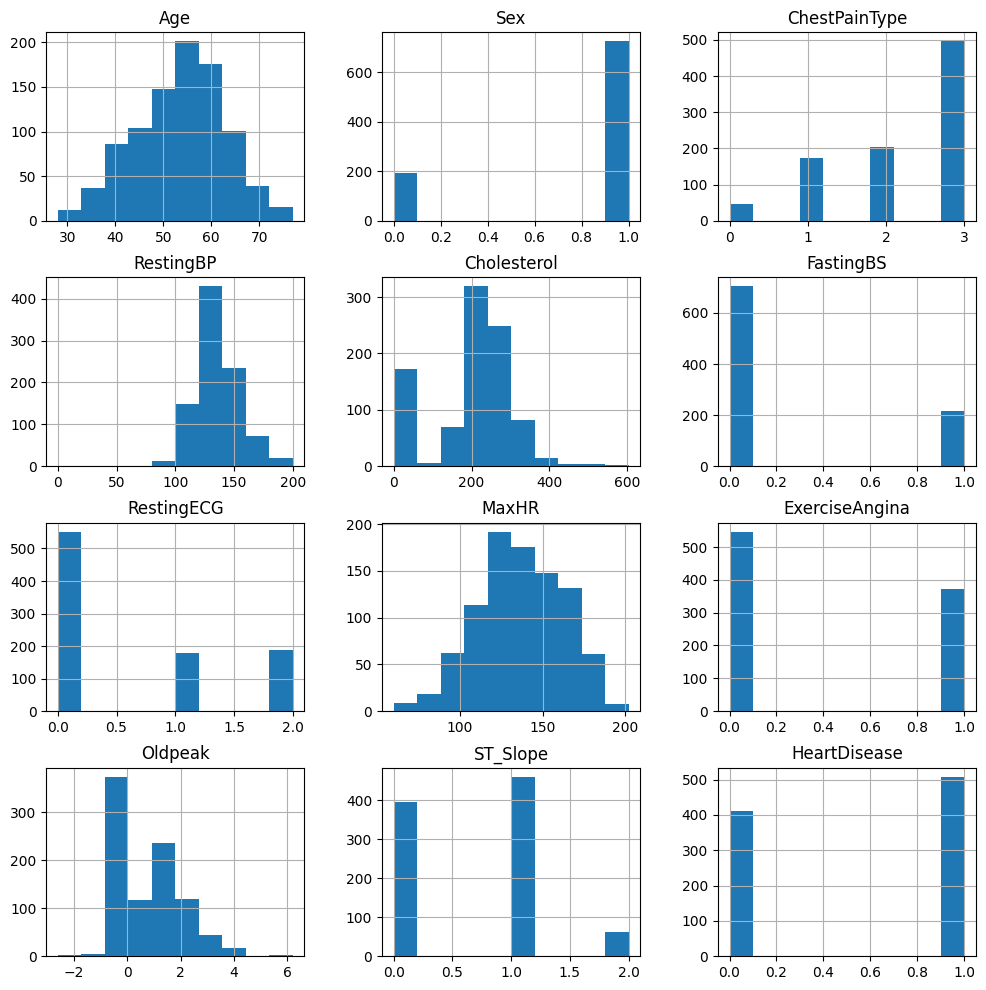

In [23]:
# plot histograms for each variable
df.hist(figsize = (12, 12))
plt.show()

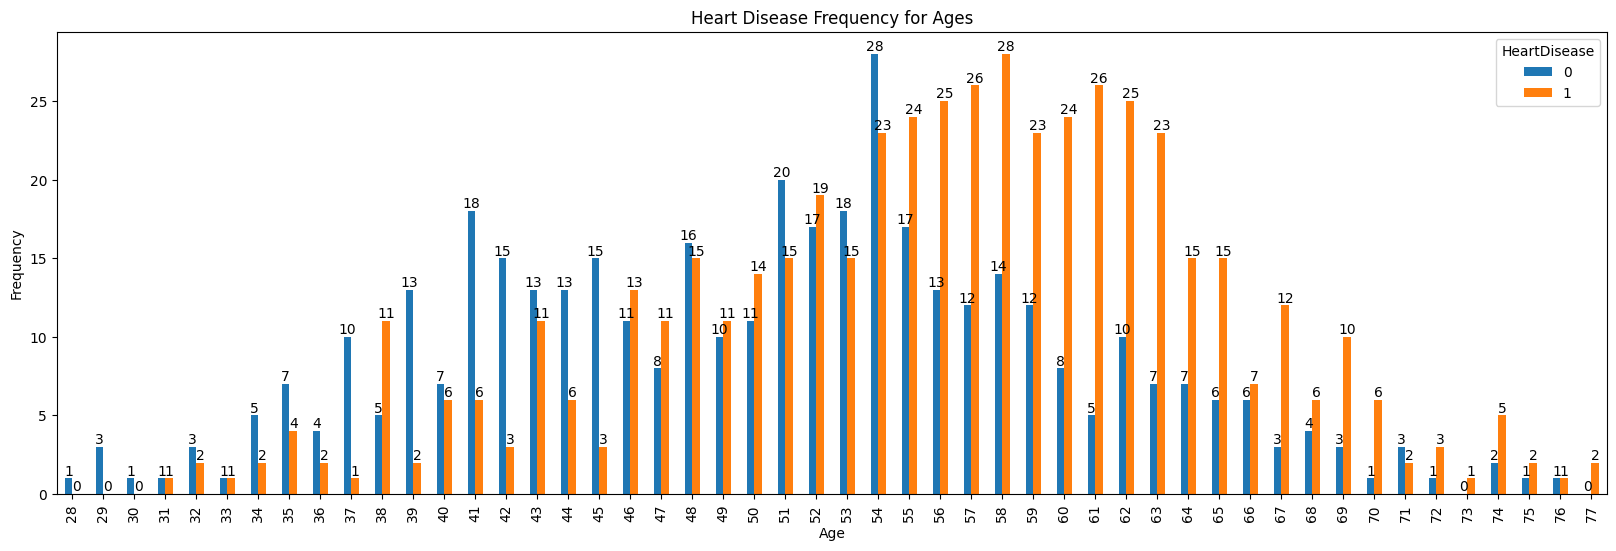

In [24]:
ax = pd.crosstab(df.Age, df.HeartDisease).plot(kind="bar", figsize=(20,6))

# Adding count labels to the bars
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

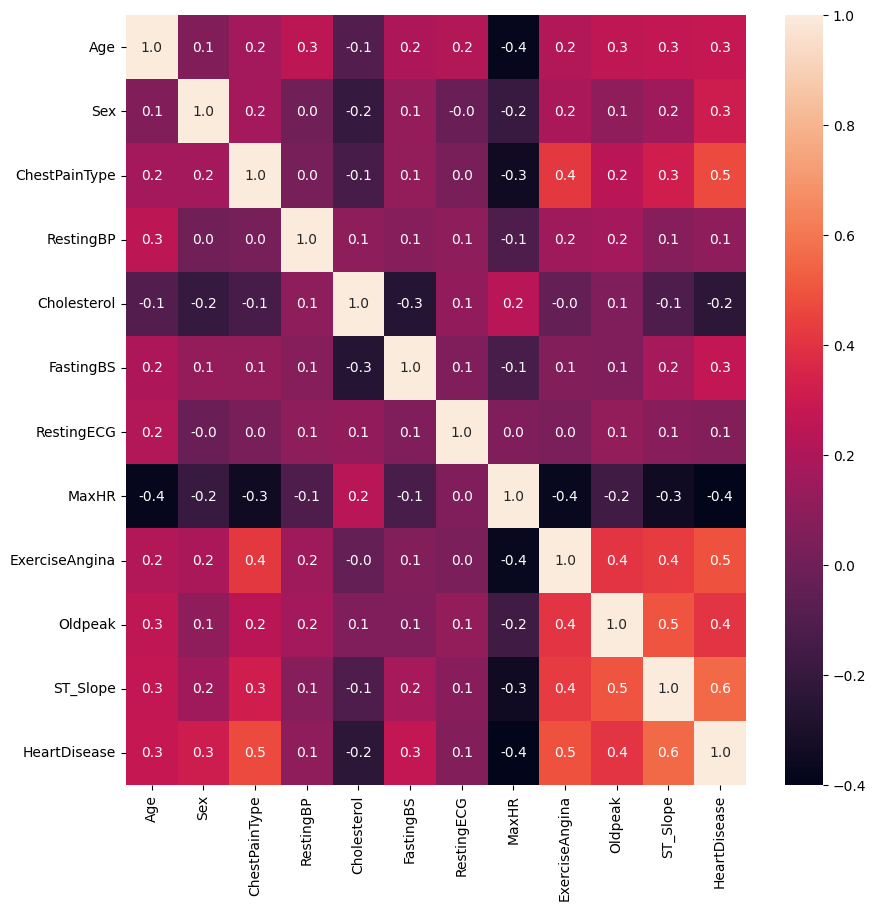

In [25]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,fmt='.1f')
plt.show()

### Data Pre-Processing

In [26]:
X = np.array(df.drop(['HeartDisease'], axis=1))   #independant

In [27]:
y = np.array(df['HeartDisease']) #dependant var

In [28]:
X

array([[40. ,  1. ,  1. , ...,  0. ,  0. ,  0. ],
       [49. ,  0. ,  2. , ...,  0. ,  1. ,  1. ],
       [37. ,  1. ,  1. , ...,  0. ,  0. ,  0. ],
       ...,
       [57. ,  1. ,  3. , ...,  1. ,  1.2,  1. ],
       [57. ,  0. ,  1. , ...,  0. ,  0. ,  1. ],
       [38. ,  1. ,  2. , ...,  0. ,  0. ,  0. ]])

In [29]:
y

array([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

In [31]:
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (734, 11), y_train: (734,)
X_test: (184, 11), y_test: (184,)


#### Standardize X_train

In [32]:
scaler = StandardScaler()

In [33]:
X_train_scaled = scaler.fit_transform(X_train)

In [34]:
X_train_scaled

array([[ 0.9700116 ,  0.51740017, -1.33199201, ...,  1.20277457,
         0.31704567,  0.60472665],
       [ 0.12202766,  0.51740017, -1.33199201, ..., -0.83141099,
        -0.44035554, -1.06395516],
       [ 0.54601963, -1.93273999,  0.79109623, ...,  1.20277457,
         0.60107112,  0.60472665],
       ...,
       [ 0.54601963,  0.51740017,  0.79109623, ...,  1.20277457,
         0.41172082,  2.27340846],
       [ 0.75801561,  0.51740017,  0.79109623, ...,  1.20277457,
        -0.81905614, -1.06395516],
       [-0.93795226,  0.51740017,  0.79109623, ..., -0.83141099,
        -0.81905614, -1.06395516]])

In [35]:
# Save the scaler object using joblib
joblib.dump(scaler, 'scaler_obj.joblib')

['scaler_obj.joblib']

In [36]:
# Load the scaler object using joblib
loaded_scaler = joblib.load('scaler_obj.joblib')

In [37]:
# Scale the X_test
X_test_scaled = loaded_scaler.transform(X_test)

In [38]:
X_test_scaled

array([[-0.83195427,  0.51740017,  0.79109623, ...,  1.20277457,
         0.60107112,  0.60472665],
       [ 0.44002164,  0.51740017, -0.27044789, ..., -0.83141099,
         2.21054868, -1.06395516],
       [ 0.65201762,  0.51740017,  0.79109623, ...,  1.20277457,
         1.83184808,  0.60472665],
       ...,
       [-0.51396029,  0.51740017, -2.39353614, ..., -0.83141099,
         2.02119838,  0.60472665],
       [ 0.54601963,  0.51740017,  0.79109623, ...,  1.20277457,
         0.31704567,  0.60472665],
       [ 0.33402364,  0.51740017, -0.27044789, ..., -0.83141099,
        -0.53503069,  0.60472665]])

# Model Selection

In [39]:
import os

# Create directories if they don't exist
if not os.path.exists('scaled_models'):
    os.makedirs('scaled_models')
if not os.path.exists('unscaled_models'):
    os.makedirs('unscaled_models')

## 1. Logistic Regression

#### For Original Data

In [69]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [70]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],
    'max_iter': [100, 200, 300]
}

In [71]:
lr = LogisticRegression(random_state=1234)

In [72]:
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')

In [73]:
grid_search.fit(X_train, y_train)

C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\

C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\

C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\

C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    htt

C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\

C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\

C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_s

C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\

C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\

C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\

C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\

C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\

C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\sukan\anaconda3\envs\

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=1234),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'max_iter': [100, 200, 300], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag',
                                    'saga']},
             scoring='accuracy')

In [74]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 100, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


In [75]:
best_lr = grid_search.best_estimator_

In [76]:
lr_prediction = best_lr.predict(X_test)

Confusion Matrix:
[[67 15]
 [ 8 94]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85        82
           1       0.86      0.92      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.87       184
weighted avg       0.88      0.88      0.87       184

Testing Accuracy for Logistic Regression: 0.875
Testing Sensitivity for Logistic Regression: 0.8933333333333333
Testing Specificity for Logistic Regression: 0.8623853211009175
Testing Precision for Logistic Regression: 0.8170731707317073


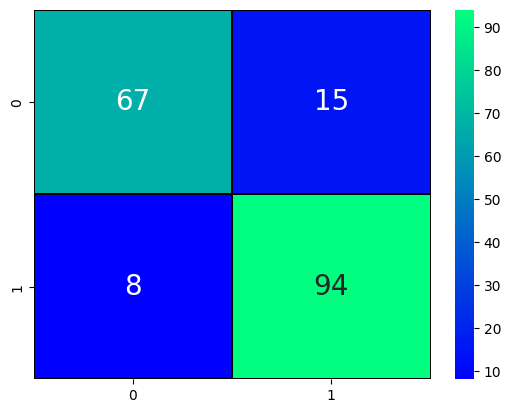

In [77]:
cm = confusion_matrix(y_test, lr_prediction)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, lr_prediction))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='winter', linewidths=0.3, linecolor='black', annot_kws={"size": 20})

TP=cm[0][0]
TN=cm[1][1]
FN=cm[1][0]
FP=cm[0][1]

print('Testing Accuracy for Logistic Regression:',(TP+TN)/(TP+TN+FN+FP))
print('Testing Sensitivity for Logistic Regression:',(TP/(TP+FN)))
print('Testing Specificity for Logistic Regression:',(TN/(TN+FP)))
print('Testing Precision for Logistic Regression:',(TP/(TP+FP)))

In [78]:
# Evaluate the model using cross-validation
scores = cross_val_score(best_lr, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)

# Calculate and print the mean of cross-validation scores
print("Mean Cross-Validation Score:", scores.mean())

Cross-Validation Scores: [0.88435374 0.88435374 0.85034014 0.81632653 0.81506849]
Mean Cross-Validation Score: 0.8500885285621098


C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

#### For Scaled Data

In [79]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],
    'max_iter': [100, 200, 300]
}

lr = LogisticRegression(random_state=1234)
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py", line 1169, in 

Confusion Matrix:
[[69 13]
 [ 9 93]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        82
           1       0.88      0.91      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184

Testing Accuracy for Logistic Regression: 0.8804347826086957
Testing Sensitivity for Logistic Regression: 0.8846153846153846
Testing Specificity for Logistic Regression: 0.8773584905660378
Testing Precision for Logistic Regression: 0.8414634146341463


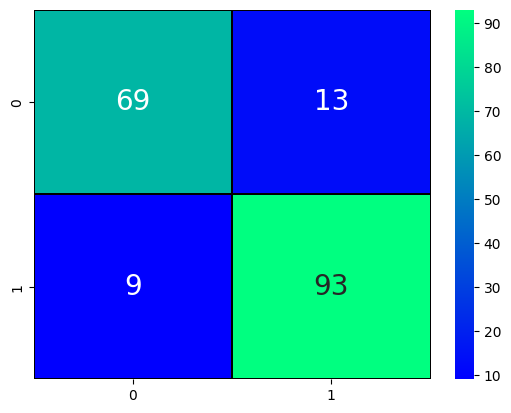

In [80]:
best_lr_scaled = grid_search.best_estimator_
lr_prediction_scaled = best_lr_scaled.predict(X_test_scaled)
cm = confusion_matrix(y_test, lr_prediction_scaled)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, lr_prediction_scaled))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='winter', linewidths=0.3, linecolor='black', annot_kws={"size": 20})

TP=cm[0][0]
TN=cm[1][1]
FN=cm[1][0]
FP=cm[0][1]

print('Testing Accuracy for Logistic Regression:',(TP+TN)/(TP+TN+FN+FP))
print('Testing Sensitivity for Logistic Regression:',(TP/(TP+FN)))
print('Testing Specificity for Logistic Regression:',(TN/(TN+FP)))
print('Testing Precision for Logistic Regression:',(TP/(TP+FP)))

In [81]:
# Evaluate the model using cross-validation
scores = cross_val_score(best_lr_scaled, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)

# Calculate and print the mean of cross-validation scores
print("Mean Cross-Validation Score:", scores.mean())

Cross-Validation Scores: [0.89795918 0.89115646 0.85034014 0.80952381 0.80136986]
Mean Cross-Validation Score: 0.8500698909700868


In [91]:
# Save the Scaled model

joblib.dump(best_lr_scaled, 'scaled_models/lr_scaled_model.pkl')

# Save the unscaled model
joblib.dump(best_lr, 'unscaled_models/lr_unscaled_model.pkl')

['unscaled_models/lr_unscaled_model.pkl']

# 2. Decision Tree

#### For Original Data

In [85]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None] + list(np.arange(1, 21)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Instantiate Decision Tree classifier
dt = DecisionTreeClassifier(random_state=1234)

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(dt, param_distributions=param_grid, n_iter=100, cv=5, scoring='accuracy', random_state=1234)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'splitter': 'random', 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 14, 'criterion': 'gini'}


C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
160 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_paramet

Confusion Matrix:
[[65 17]
 [20 82]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78        82
           1       0.83      0.80      0.82       102

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.80      0.80      0.80       184

Testing Accuracy for Decision Tree: 0.7989130434782609
Testing Sensitivity for Decision Tree: 0.7647058823529411
Testing Specificity for Decision Tree: 0.8282828282828283
Testing Precision for Decision Tree: 0.7926829268292683


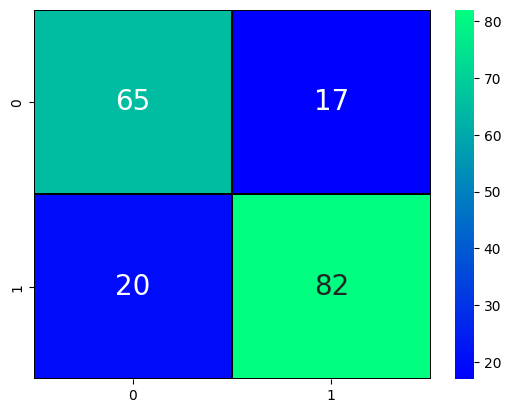

In [86]:
# Get the best estimator
best_dt = random_search.best_estimator_

# Use the best estimator for prediction
dt_prediction = best_dt.predict(X_test)

# Evaluate the model and print metrics
cm = confusion_matrix(y_test, dt_prediction)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, dt_prediction))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='winter', linewidths=0.3, linecolor='black', annot_kws={"size": 20})

TP=cm[0][0]
TN=cm[1][1]
FN=cm[1][0]
FP=cm[0][1]

print('Testing Accuracy for Decision Tree:',(TP+TN)/(TP+TN+FN+FP))
print('Testing Sensitivity for Decision Tree:',(TP/(TP+FN)))
print('Testing Specificity for Decision Tree:',(TN/(TN+FP)))
print('Testing Precision for Decision Tree:',(TP/(TP+FP)))

In [87]:
# Evaluate the model using cross-validation
scores = cross_val_score(best_dt, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)

# Calculate and print the mean of cross-validation scores
print("Mean Cross-Validation Score:", scores.mean())

Cross-Validation Scores: [0.85714286 0.86394558 0.8707483  0.84353741 0.82191781]
Mean Cross-Validation Score: 0.8514583915758085


#### For Scaled Data

In [88]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None] + list(np.arange(1, 21)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Instantiate Decision Tree classifier
dt = DecisionTreeClassifier(random_state=1234)

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(dt, param_distributions=param_grid, n_iter=100, cv=5, scoring='accuracy', random_state=1234)

# Fit the random search to the data
random_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'splitter': 'random', 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 14, 'criterion': 'gini'}


C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
160 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_paramet

Confusion Matrix:
[[72 10]
 [78 24]]
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.88      0.62        82
           1       0.71      0.24      0.35       102

    accuracy                           0.52       184
   macro avg       0.59      0.56      0.49       184
weighted avg       0.61      0.52      0.47       184

Testing Accuracy for Decision Tree: 0.5217391304347826
Testing Sensitivity for Decision Tree: 0.48
Testing Specificity for Decision Tree: 0.7058823529411765
Testing Precision for Decision Tree: 0.8780487804878049


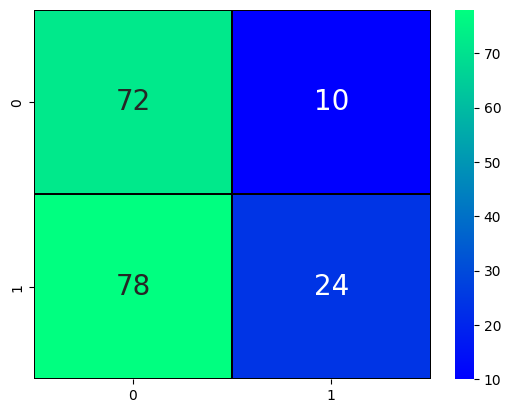

In [89]:
# Get the best estimator
best_dt_scaled = random_search.best_estimator_

# Use the best estimator for prediction
dt_prediction_scaled = best_dt.predict(X_test_scaled)

# Evaluate the model and print metrics
cm = confusion_matrix(y_test, dt_prediction_scaled)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, dt_prediction_scaled))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='winter', linewidths=0.3, linecolor='black', annot_kws={"size": 20})

TP=cm[0][0]
TN=cm[1][1]
FN=cm[1][0]
FP=cm[0][1]

print('Testing Accuracy for Decision Tree:',(TP+TN)/(TP+TN+FN+FP))
print('Testing Sensitivity for Decision Tree:',(TP/(TP+FN)))
print('Testing Specificity for Decision Tree:',(TN/(TN+FP)))
print('Testing Precision for Decision Tree:',(TP/(TP+FP)))

In [90]:
# Evaluate the model using cross-validation
scores = cross_val_score(best_dt_scaled, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)

# Calculate and print the mean of cross-validation scores
print("Mean Cross-Validation Score:", scores.mean())

Cross-Validation Scores: [0.85714286 0.86394558 0.8707483  0.84353741 0.82191781]
Mean Cross-Validation Score: 0.8514583915758085


In [92]:
# Save the Scaled model

joblib.dump(best_dt_scaled, 'scaled_models/dt_scaled_model.pkl')

# Save the unscaled model
joblib.dump(best_dt, 'unscaled_models/dt_unscaled_model.pkl')

['unscaled_models/dt_unscaled_model.pkl']

# 3. Random Forest Classifier

#### Original Data

In [93]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(np.arange(10, 110, 10)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Instantiate Random Forest classifier
rf = RandomForestClassifier(random_state=1234)

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=100, cv=5, scoring='accuracy', random_state=1234)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini'}


C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
180 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_paramet

Confusion Matrix:
[[72 10]
 [ 6 96]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        82
           1       0.91      0.94      0.92       102

    accuracy                           0.91       184
   macro avg       0.91      0.91      0.91       184
weighted avg       0.91      0.91      0.91       184

Testing Accuracy for Random Forest: 0.9130434782608695
Testing Sensitivity for Random Forest: 0.9230769230769231
Testing Specificity for Random Forest: 0.9056603773584906
Testing Precision for Random Forest: 0.8780487804878049


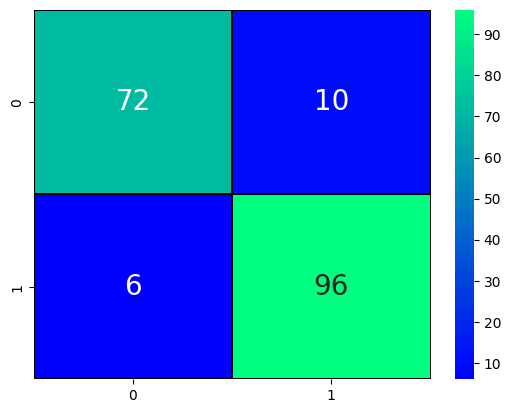

In [94]:
# Get the best estimator
best_rf = random_search.best_estimator_

# Use the best estimator for prediction
rf_prediction = best_rf.predict(X_test)

# Evaluate the model and print metrics
cm = confusion_matrix(y_test, rf_prediction)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, rf_prediction))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='winter', linewidths=0.3, linecolor='black', annot_kws={"size": 20})

TP=cm[0][0]
TN=cm[1][1]
FN=cm[1][0]
FP=cm[0][1]
print('Testing Accuracy for Random Forest:',(TP+TN)/(TP+TN+FN+FP))
print('Testing Sensitivity for Random Forest:',(TP/(TP+FN)))
print('Testing Specificity for Random Forest:',(TN/(TN+FP)))
print('Testing Precision for Random Forest:',(TP/(TP+FP)))

In [95]:
# Evaluate the model using cross-validation
scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)

# Calculate and print the mean of cross-validation scores
print("Mean Cross-Validation Score:", scores.mean())

Cross-Validation Scores: [0.89115646 0.88435374 0.85714286 0.8707483  0.83561644]
Mean Cross-Validation Score: 0.8678035597800765


#### For Scaled Data

In [96]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(np.arange(10, 110, 10)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Instantiate Random Forest classifier
rf = RandomForestClassifier(random_state=1234)

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=100, cv=5, scoring='accuracy', random_state=1234)

# Fit the random search to the data
random_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'entropy'}


C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
180 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_paramet

Confusion Matrix:
[[68 14]
 [ 7 95]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        82
           1       0.87      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184

Testing Accuracy for Random Forest: 0.8858695652173914
Testing Sensitivity for Random Forest: 0.9066666666666666
Testing Specificity for Random Forest: 0.8715596330275229
Testing Precision for Random Forest: 0.8292682926829268


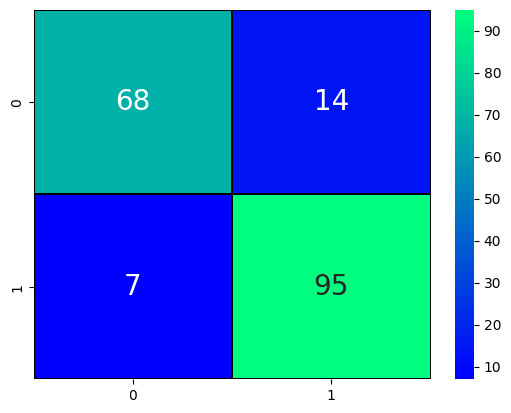

In [97]:
# Get the best estimator
best_rf_scaled = random_search.best_estimator_

# Use the best estimator for prediction
rf_prediction_scaled = best_rf_scaled.predict(X_test_scaled)

# Evaluate the model and print metrics
cm = confusion_matrix(y_test, rf_prediction_scaled)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, rf_prediction_scaled))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='winter', linewidths=0.3, linecolor='black', annot_kws={"size": 20})

TP=cm[0][0]
TN=cm[1][1]
FN=cm[1][0]
FP=cm[0][1]
print('Testing Accuracy for Random Forest:',(TP+TN)/(TP+TN+FN+FP))
print('Testing Sensitivity for Random Forest:',(TP/(TP+FN)))
print('Testing Specificity for Random Forest:',(TN/(TN+FP)))
print('Testing Precision for Random Forest:',(TP/(TP+FP)))

In [98]:
# Evaluate the model using cross-validation
scores = cross_val_score(best_rf_scaled, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)

# Calculate and print the mean of cross-validation scores
print("Mean Cross-Validation Score:", scores.mean())

Cross-Validation Scores: [0.89115646 0.86394558 0.8707483  0.89115646 0.82876712]
Mean Cross-Validation Score: 0.8691547852017518


In [99]:
# Save the Scaled model

joblib.dump(best_rf_scaled, 'scaled_models/rf_scaled_model.pkl')

# Save the unscaled model
joblib.dump(best_rf, 'unscaled_models/rf_unscaled_model.pkl')

['unscaled_models/rf_unscaled_model.pkl']

# 4. SVM

#### Original Data

In [100]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}

# Instantiate Support Vector Machine (SVM) classifier
svm = SVC(random_state=1234)

# Instantiate GridSearchCV
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


Confusion Matrix:
[[69 13]
 [ 9 93]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        82
           1       0.88      0.91      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184

Testing Accuracy for SVM: 0.8804347826086957
Testing Sensitivity for SVM: 0.8846153846153846
Testing Specificity for SVM: 0.8773584905660378
Testing Precision for SVM: 0.8414634146341463


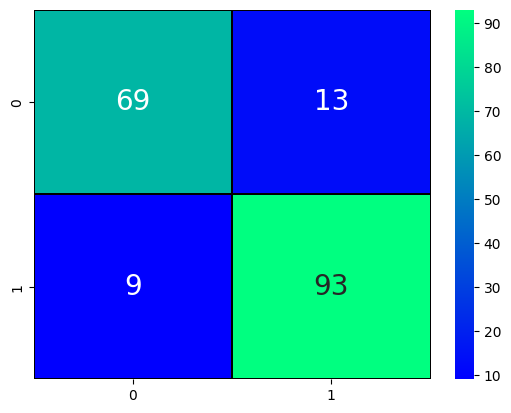

In [101]:
# Get the best estimator
best_svm = grid_search.best_estimator_

# Use the best estimator for prediction
svm_prediction = best_svm.predict(X_test)

# Evaluate the model and print metrics
cm = confusion_matrix(y_test, svm_prediction)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, svm_prediction))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='winter', linewidths=0.3, linecolor='black', annot_kws={"size": 20})

TP=cm[0][0]
TN=cm[1][1]
FN=cm[1][0]
FP=cm[0][1]

print('Testing Accuracy for SVM:',(TP+TN)/(TP+TN+FN+FP))
print('Testing Sensitivity for SVM:',(TP/(TP+FN)))
print('Testing Specificity for SVM:',(TN/(TN+FP)))
print('Testing Precision for SVM:',(TP/(TP+FP)))

In [102]:
# Evaluate the model using cross-validation
scores = cross_val_score(best_svm, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)

# Calculate and print the mean of cross-validation scores
print("Mean Cross-Validation Score:", scores.mean())

Cross-Validation Scores: [0.87755102 0.8707483  0.85034014 0.84353741 0.80821918]
Mean Cross-Validation Score: 0.8500792097660982


#### For Scaled Data

In [103]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Define a reduced parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}

# Instantiate Support Vector Machine (SVM) classifier
svm = SVC(random_state=1234)

# Instantiate RandomizedSearchCV with reduced parameters
random_search = RandomizedSearchCV(svm, param_distributions=param_grid, n_iter=100, cv=5, scoring='accuracy', random_state=1234)

# Fit the random search to the data
random_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

C:\Users\sukan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 16 is smaller than n_iter=100. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}


Confusion Matrix:
[[73  9]
 [33 69]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.89      0.78        82
           1       0.88      0.68      0.77       102

    accuracy                           0.77       184
   macro avg       0.79      0.78      0.77       184
weighted avg       0.80      0.77      0.77       184

Testing Accuracy for SVM: 0.7717391304347826
Testing Sensitivity for SVM: 0.6886792452830188
Testing Specificity for SVM: 0.8846153846153846
Testing Precision for SVM: 0.8902439024390244


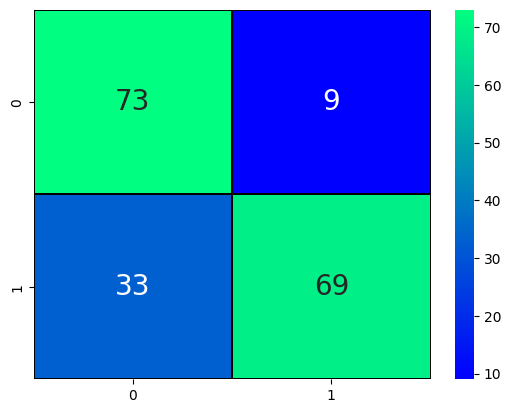

In [104]:
# Get the best estimator
best_svm_scaled = grid_search.best_estimator_

# Use the best estimator for prediction
svm_prediction_scaled = best_svm_scaled.predict(X_test_scaled)

# Evaluate the model and print metrics
cm = confusion_matrix(y_test, svm_prediction_scaled)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, svm_prediction_scaled))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='winter', linewidths=0.3, linecolor='black', annot_kws={"size": 20})

TP=cm[0][0]
TN=cm[1][1]
FN=cm[1][0]
FP=cm[0][1]

print('Testing Accuracy for SVM:',(TP+TN)/(TP+TN+FN+FP))
print('Testing Sensitivity for SVM:',(TP/(TP+FN)))
print('Testing Specificity for SVM:',(TN/(TN+FP)))
print('Testing Precision for SVM:',(TP/(TP+FP)))

In [105]:
# Evaluate the model using cross-validation
scores = cross_val_score(best_svm_scaled, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)

# Calculate and print the mean of cross-validation scores
print("Mean Cross-Validation Score:", scores.mean())

Cross-Validation Scores: [0.87755102 0.82993197 0.84353741 0.84353741 0.78767123]
Mean Cross-Validation Score: 0.8364458112011928


In [106]:
# Save the Scaled model

joblib.dump(best_svm_scaled, 'scaled_models/svm_scaled_model.pkl')

# Save the unscaled model
joblib.dump(best_svm, 'unscaled_models/svm_unscaled_model.pkl')

['unscaled_models/svm_unscaled_model.pkl']

# 5. K-Nearest Neighbor

#### For Original Data

In [107]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]  # p=1 for Manhattan distance, p=2 for Euclidean distance
}

# Instantiate K-Nearest Neighbors (KNN) classifier
knn = KNeighborsClassifier()

# Instantiate GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}


Confusion Matrix:
[[57 25]
 [22 80]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        82
           1       0.76      0.78      0.77       102

    accuracy                           0.74       184
   macro avg       0.74      0.74      0.74       184
weighted avg       0.74      0.74      0.74       184

Testing Accuracy for KNN: 0.7445652173913043
Testing Sensitivity for KNN: 0.7215189873417721
Testing Specificity for KNN: 0.7619047619047619
Testing Precision for KNN: 0.6951219512195121


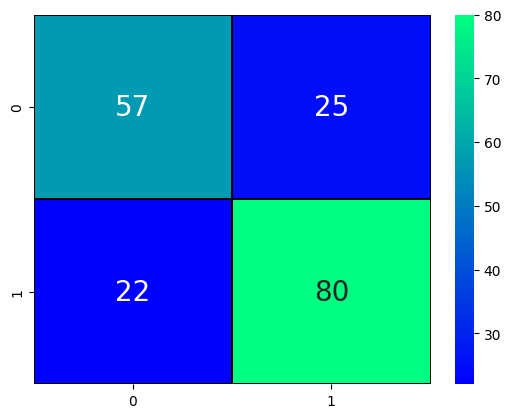

In [108]:
# Get the best estimator
best_knn = grid_search.best_estimator_

# Use the best estimator for prediction
knn_prediction = best_knn.predict(X_test)

# Evaluate the model and print metrics
cm = confusion_matrix(y_test, knn_prediction)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, knn_prediction))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='winter', linewidths=0.3, linecolor='black', annot_kws={"size": 20})

TP=cm[0][0]
TN=cm[1][1]
FN=cm[1][0]
FP=cm[0][1]

print('Testing Accuracy for KNN:',(TP+TN)/(TP+TN+FN+FP))
print('Testing Sensitivity for KNN:',(TP/(TP+FN)))
print('Testing Specificity for KNN:',(TN/(TN+FP)))
print('Testing Precision for KNN:',(TP/(TP+FP)))

In [109]:
# Evaluate the model using cross-validation
scores = cross_val_score(best_knn, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)

# Calculate and print the mean of cross-validation scores
print("Mean Cross-Validation Score:", scores.mean())

Cross-Validation Scores: [0.82993197 0.7755102  0.74829932 0.71428571 0.69863014]
Mean Cross-Validation Score: 0.7533314695741311


#### For Scaled Data

In [110]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]  # p=1 for Manhattan distance, p=2 for Euclidean distance
}

# Instantiate K-Nearest Neighbors (KNN) classifier
knn = KNeighborsClassifier()

# Instantiate GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}


Confusion Matrix:
[[72 10]
 [ 8 94]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        82
           1       0.90      0.92      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

Testing Accuracy for KNN: 0.9021739130434783
Testing Sensitivity for KNN: 0.9
Testing Specificity for KNN: 0.9038461538461539
Testing Precision for KNN: 0.8780487804878049


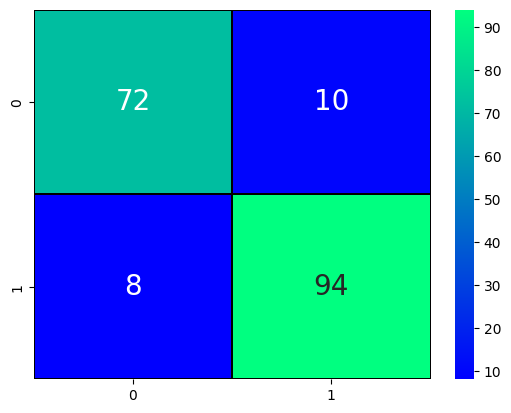

In [111]:
# Get the best estimator
best_knn_scaled = grid_search.best_estimator_

# Use the best estimator for prediction
knn_prediction_scaled = best_knn_scaled.predict(X_test_scaled)

# Evaluate the model and print metrics
cm = confusion_matrix(y_test, knn_prediction_scaled)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, knn_prediction_scaled))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='winter', linewidths=0.3, linecolor='black', annot_kws={"size": 20})

TP=cm[0][0]
TN=cm[1][1]
FN=cm[1][0]
FP=cm[0][1]

print('Testing Accuracy for KNN:',(TP+TN)/(TP+TN+FN+FP))
print('Testing Sensitivity for KNN:',(TP/(TP+FN)))
print('Testing Specificity for KNN:',(TN/(TN+FP)))
print('Testing Precision for KNN:',(TP/(TP+FP)))

In [112]:
# Evaluate the model using cross-validation
scores = cross_val_score(best_knn_scaled, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)

# Calculate and print the mean of cross-validation scores
print("Mean Cross-Validation Score:", scores.mean())

Cross-Validation Scores: [0.8707483  0.86394558 0.86394558 0.89115646 0.83561644]
Mean Cross-Validation Score: 0.8650824713447023


In [113]:
# Save the Scaled model

joblib.dump(best_knn_scaled, 'scaled_models/knn_scaled_model.pkl')

# Save the unscaled model
joblib.dump(best_knn, 'unscaled_models/knn_unscaled_model.pkl')

['unscaled_models/knn_unscaled_model.pkl']

# 6. XGBoost Classifier

#### For Original Data

In [114]:
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define a reduced parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [100, 200],
}

# Instantiate XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=1234)

# Instantiate GridSearchCV
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Confusion Matrix:
[[73  9]
 [10 92]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88        82
           1       0.91      0.90      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

Testing Accuracy for XGB: 0.8967391304347826
Testing Sensitivity for XGB: 0.8795180722891566
Testing Specificity for XGB: 0.9108910891089109
Testing Precision for XGB: 0.8902439024390244


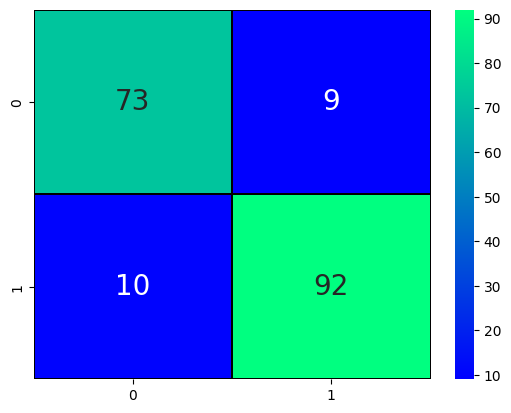

In [115]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best estimator
best_xgb = grid_search.best_estimator_

# Use the best estimator for prediction
xgb_prediction = best_xgb.predict(X_test)

# Evaluate the model and print metrics
cm = confusion_matrix(y_test, xgb_prediction)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, xgb_prediction))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='winter', linewidths=0.3, linecolor='black', annot_kws={"size": 20})

TP=cm[0][0]
TN=cm[1][1]
FN=cm[1][0]
FP=cm[0][1]

print('Testing Accuracy for XGB:',(TP+TN)/(TP+TN+FN+FP))
print('Testing Sensitivity for XGB:',(TP/(TP+FN)))
print('Testing Specificity for XGB:',(TN/(TN+FP)))
print('Testing Precision for XGB:',(TP/(TP+FP)))

In [116]:
# Evaluate the model using cross-validation
scores = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)

# Calculate and print the mean of cross-validation scores
print("Mean Cross-Validation Score:", scores.mean())

Cross-Validation Scores: [0.89115646 0.83673469 0.86394558 0.84353741 0.82191781]
Mean Cross-Validation Score: 0.8514583915758085


#### For Scaled Data

In [117]:
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define a reduced parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [100, 200],
}

# Instantiate XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=1234)

# Instantiate GridSearchCV
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


Confusion Matrix:
[[73  9]
 [10 92]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88        82
           1       0.91      0.90      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

Testing Accuracy for XGB: 0.8967391304347826
Testing Sensitivity for XGB: 0.8795180722891566
Testing Specificity for XGB: 0.9108910891089109
Testing Precision for XGB: 0.8902439024390244


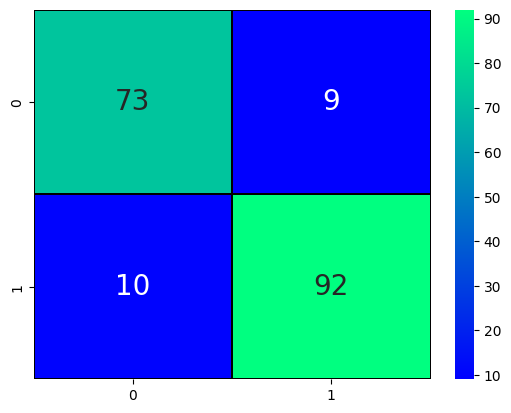

In [118]:
# Get the best estimator
best_xgb_scaled = grid_search.best_estimator_

# Use the best estimator for prediction
xgb_prediction_scaled = best_xgb_scaled.predict(X_test_scaled)

# Evaluate the model and print metrics
cm = confusion_matrix(y_test, xgb_prediction_scaled)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, xgb_prediction_scaled))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='winter', linewidths=0.3, linecolor='black', annot_kws={"size": 20})

TP=cm[0][0]
TN=cm[1][1]
FN=cm[1][0]
FP=cm[0][1]

print('Testing Accuracy for XGB:',(TP+TN)/(TP+TN+FN+FP))
print('Testing Sensitivity for XGB:',(TP/(TP+FN)))
print('Testing Specificity for XGB:',(TN/(TN+FP)))
print('Testing Precision for XGB:',(TP/(TP+FP)))

In [119]:
# Evaluate the model using cross-validation
scores = cross_val_score(best_xgb_scaled, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)

# Calculate and print the mean of cross-validation scores
print("Mean Cross-Validation Score:", scores.mean())

Cross-Validation Scores: [0.89115646 0.83673469 0.86394558 0.84353741 0.82191781]
Mean Cross-Validation Score: 0.8514583915758085


In [120]:
# Save the Scaled model

joblib.dump(best_xgb_scaled, 'scaled_models/xgb_scaled_model.pkl')

# Save the unscaled model
joblib.dump(best_xgb, 'unscaled_models/xgb_unscaled_model.pkl')

['unscaled_models/xgb_unscaled_model.pkl']

# 7. Deep Learning Model

In [59]:
def create_finetuned_binary_model(learning_rate=0.0004, dropout_rate=0.5, regularization_strength=0.01):
    model = Sequential()
    model.add(Dense(16, input_dim=11, kernel_initializer='normal', kernel_regularizer=regularizers.l2(regularization_strength), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(8, kernel_initializer='normal', kernel_regularizer=regularizers.l2(regularization_strength), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model with fine-tuned parameters
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

finetuned_binary_model = create_finetuned_binary_model()

print(finetuned_binary_model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 16)                192       
                                                                 
 dropout_12 (Dropout)        (None, 16)                0         
                                                                 
 dense_19 (Dense)            (None, 8)                 136       
                                                                 
 dropout_13 (Dropout)        (None, 8)                 0         
                                                                 
 dense_20 (Dense)            (None, 1)                 9         
                                                                 
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
# fit the finetuned binary model on the training data
finetuned_history=finetuned_binary_model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=100, batch_size=10)

Epoch 1/100
74/74 [==============================] - 1s 9ms/step - loss: 0.6995 - accuracy: 0.5531 - val_loss: 0.6947 - val_accuracy: 0.7717
Epoch 2/100
74/74 [==============================] - 0s 6ms/step - loss: 0.6902 - accuracy: 0.6826 - val_loss: 0.6821 - val_accuracy: 0.8370
Epoch 3/100
74/74 [==============================] - 0s 6ms/step - loss: 0.6780 - accuracy: 0.7221 - val_loss: 0.6605 - val_accuracy: 0.8478
Epoch 4/100
74/74 [==============================] - 0s 6ms/step - loss: 0.6513 - accuracy: 0.7779 - val_loss: 0.6238 - val_accuracy: 0.8587
Epoch 5/100
74/74 [==============================] - 0s 6ms/step - loss: 0.6163 - accuracy: 0.8011 - val_loss: 0.5771 - val_accuracy: 0.8641
Epoch 6/100
74/74 [==============================] - 0s 7ms/step - loss: 0.5718 - accuracy: 0.7997 - val_loss: 0.5290 - val_accuracy: 0.8750
Epoch 7/100
74/74 [==============================] - 0s 6ms/step - loss: 0.5736 - accuracy: 0.7888 - val_loss: 0.4980 - val_accuracy: 0.8750
Epoch 8/100
7

Epoch 59/100
74/74 [==============================] - 0s 6ms/step - loss: 0.4687 - accuracy: 0.8174 - val_loss: 0.3879 - val_accuracy: 0.8750
Epoch 60/100
74/74 [==============================] - 1s 9ms/step - loss: 0.4390 - accuracy: 0.8433 - val_loss: 0.3879 - val_accuracy: 0.8750
Epoch 61/100
74/74 [==============================] - 1s 8ms/step - loss: 0.4639 - accuracy: 0.8256 - val_loss: 0.3876 - val_accuracy: 0.8750
Epoch 62/100
74/74 [==============================] - 1s 9ms/step - loss: 0.4736 - accuracy: 0.8270 - val_loss: 0.3878 - val_accuracy: 0.8750
Epoch 63/100
74/74 [==============================] - 1s 7ms/step - loss: 0.4735 - accuracy: 0.8283 - val_loss: 0.3896 - val_accuracy: 0.8750
Epoch 64/100
74/74 [==============================] - 1s 7ms/step - loss: 0.4746 - accuracy: 0.8379 - val_loss: 0.3886 - val_accuracy: 0.8750
Epoch 65/100
74/74 [==============================] - 1s 8ms/step - loss: 0.4545 - accuracy: 0.8188 - val_loss: 0.3876 - val_accuracy: 0.8750
Epoch 

In [58]:
# generate classification report using predictions for binary model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# generate classification report using predictions for binary model 
finetuned_binary_pred = np.round(finetuned_binary_model.predict(X_test_scaled)).astype(int)

print('Results for Binary Model')
print(accuracy_score(y_test, finetuned_binary_pred))
print(classification_report(y_test, finetuned_binary_pred))

dl_cm= confusion_matrix(y_test,finetuned_binary_pred)
TP=dl_cm[0][0]
TN=dl_cm[1][1]
FN=dl_cm[1][0]
FP=dl_cm[0][1]
print('Testing Accuracy for DL model:',(TP+TN)/(TP+TN+FN+FP))
print('Testing Sensitivity for DL model:',(TP/(TP+FN)))
print('Testing Specificity for DL model:',(TN/(TN+FP)))
print('Testing Precision for DL model:',(TP/(TP+FP)))

6/6 [==============================] - 0s 4ms/step
Results for Binary Model
0.8804347826086957
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        82
           1       0.88      0.91      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184

Testing Accuracy for DL model: 0.8804347826086957
Testing Sensitivity for DL model: 0.8846153846153846
Testing Specificity for DL model: 0.8773584905660378
Testing Precision for DL model: 0.8414634146341463


### Finding Best Hyper Parameters for DL model using KerasTuner

In [64]:
import kerastuner as kt
from tensorflow import keras

# Define the function to create the Keras model
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=hp.Int('units_1', min_value=8, max_value=64, step=8),
                                 input_dim=11,
                                 kernel_initializer='normal',
                                 kernel_regularizer=keras.regularizers.l2(hp.Choice('regularization', values=[0.001, 0.01, 0.1])),
                                 activation='relu'))
    model.add(keras.layers.Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Compile model with fine-tuned parameters
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[0.0001, 0.001, 0.01])),
                  metrics=['accuracy'])
    
    return model

# Instantiate Keras Tuner RandomSearch tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Adjust the number of trials as needed
    directory='keras_tuner_results',
    project_name='binary_classification'
)

# Perform hyperparameter search
tuner.search(X_train_scaled, y_train, epochs=100, validation_data=(X_test_scaled, y_test))

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hyperparameters)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
print("Best Model Summary:")
print(best_model.summary())


Trial 5 Complete [00h 00m 22s]
val_accuracy: 0.8913043737411499

Best val_accuracy So Far: 0.907608687877655
Total elapsed time: 00h 01m 50s
Best Hyperparameters:
Best Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                480       
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________
None


In [65]:
# Retrieve the best hyperparameters values
best_learning_rate = best_hyperparameters.get('learning_rate')
best_units_1 = best_hyperparameters.get('units_1')
best_regularization = best_hyperparameters.get('regularization')
best_dropout = best_hyperparameters.get('dropout')

# Print the best hyperparameters values
print("Best Learning Rate:", best_learning_rate)
print("Best Number of Units in the First Dense Layer:", best_units_1)
print("Best Regularization Strength:", best_regularization)
print("Best Dropout Rate:", best_dropout)

Best Learning Rate: 0.01
Best Number of Units in the First Dense Layer: 40
Best Regularization Strength: 0.1
Best Dropout Rate: 0.4


In [46]:
# generate classification report using predictions for binary model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# generate classification report using predictions for binary model 
best_model_pred = np.round(best_model.predict(X_test_scaled)).astype(int)

print('Results for Binary Model')
print(accuracy_score(y_test, best_model_pred))
print(classification_report(y_test, best_model_pred))

dl_cm= confusion_matrix(y_test,best_model_pred)
TP=dl_cm[0][0]
TN=dl_cm[1][1]
FN=dl_cm[1][0]
FP=dl_cm[0][1]
print('Testing Accuracy for DL model:',(TP+TN)/(TP+TN+FN+FP))
print('Testing Sensitivity for DL model:',(TP/(TP+FN)))
print('Testing Specificity for DL model:',(TN/(TN+FP)))
print('Testing Precision for DL model:',(TP/(TP+FP)))

NameError: name 'best_model' is not defined

In [67]:
# Save the best model
best_model.save('dl_best_model.h5')

# Model Comparision 

### Load all the models

6/6 [==============================] - 2s 4ms/step


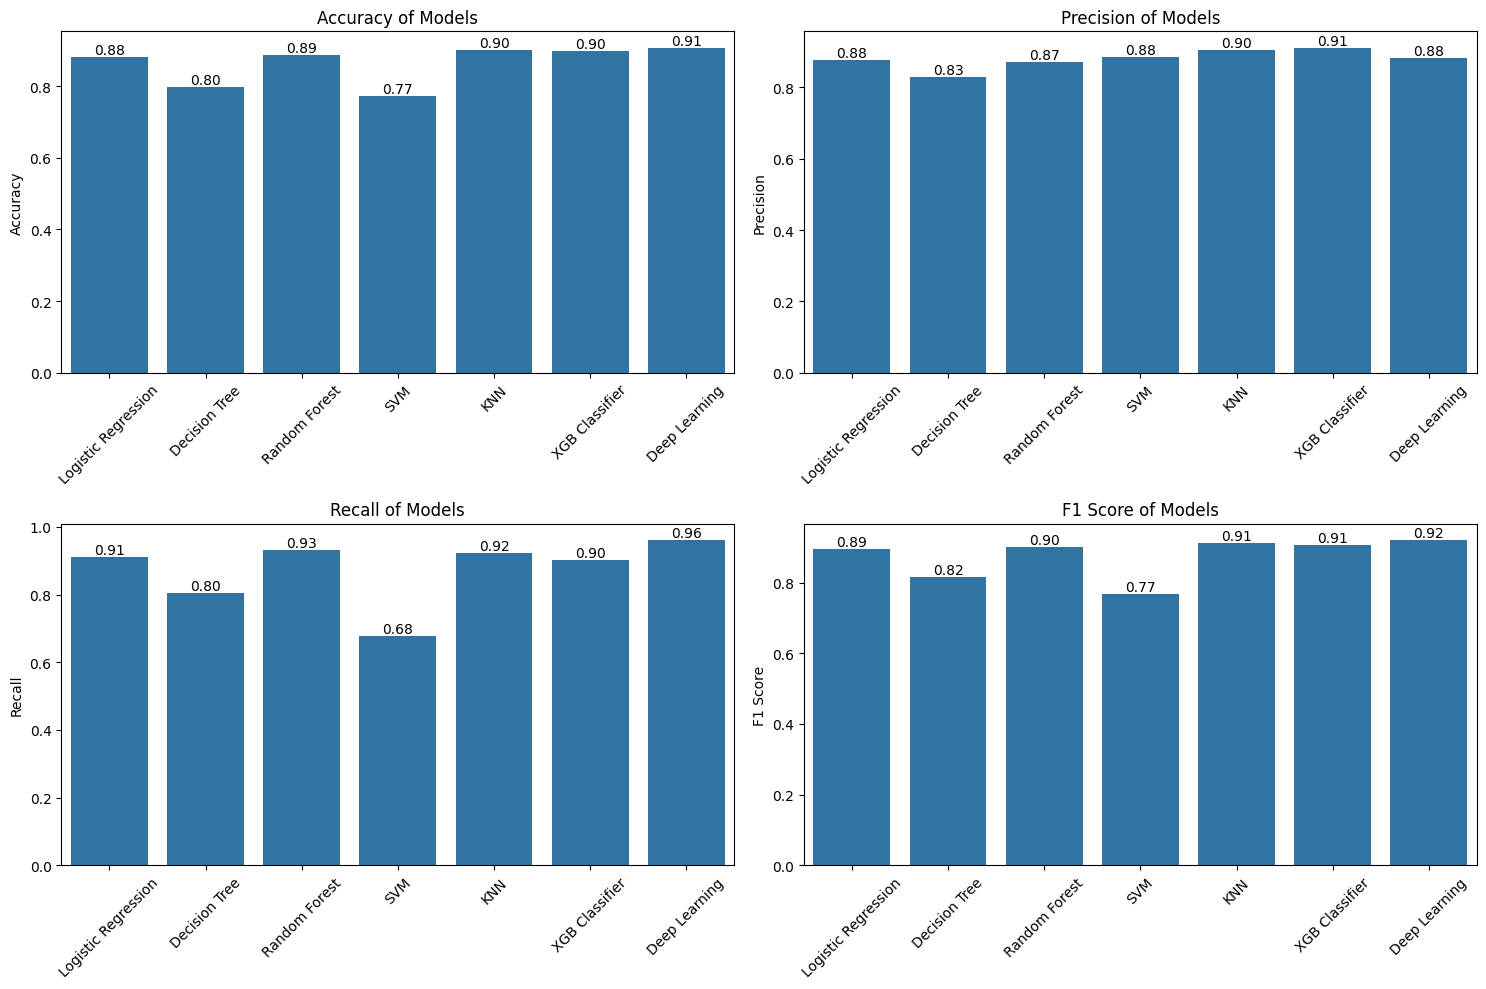

In [40]:
import joblib
from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load ML models
ml_model_filenames = ["lr_scaled_model.pkl", "dt_scaled_model.pkl", "rf_scaled_model.pkl", "svm_scaled_model.pkl", "knn_scaled_model.pkl", "xgb_scaled_model.pkl"]
dl_model_filename = "dl_best_model.h5"

ml_models = [joblib.load(f'scaled_models/{filename}') for filename in ml_model_filenames]
dl_model = load_model(f'scaled_models/{dl_model_filename}')

# Function to evaluate a model and return metrics
def evaluate_model(model, X_test_scaled, y_test):
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

# Evaluate ML models
ml_model_metrics = [evaluate_model(model, X_test_scaled, y_test) for model in ml_models]

# Evaluate deep learning model
y_pred_dl = np.round(dl_model.predict(X_test_scaled)).astype(int)
accuracy_dl = accuracy_score(y_test, y_pred_dl)
precision_dl = precision_score(y_test, y_pred_dl)
recall_dl = recall_score(y_test, y_pred_dl)
f1_dl = f1_score(y_test, y_pred_dl)

# Combine results for plotting
model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "SVM", "KNN", "XGB Classifier", "Deep Learning"]
accuracies = [metric[0] for metric in ml_model_metrics] + [accuracy_dl]
precisions = [metric[1] for metric in ml_model_metrics] + [precision_dl]
recalls = [metric[2] for metric in ml_model_metrics] + [recall_dl]
f1_scores = [metric[3] for metric in ml_model_metrics] + [f1_dl]

# Plotting
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.barplot(x=model_names, y=accuracies)
plt.title('Accuracy of Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# Adding accuracy values on bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f'{acc:.2f}', ha='center', va='bottom')


plt.subplot(2, 2, 2)
sns.barplot(x=model_names, y=precisions)
plt.title('Precision of Models')
plt.ylabel('Precision')
plt.xticks(rotation=45)

# Adding precision values on bars
for i, prec in enumerate(precisions):
    plt.text(i, prec, f'{prec:.2f}', ha='center', va='bottom')


plt.subplot(2, 2, 3)
sns.barplot(x=model_names, y=recalls)
plt.title('Recall of Models')
plt.ylabel('Recall')
plt.xticks(rotation=45)

# Adding precision values on bars
for i, rec in enumerate(recalls):
    plt.text(i, rec, f'{rec:.2f}', ha='center', va='bottom')
    

plt.subplot(2, 2, 4)
sns.barplot(x=model_names, y=f1_scores)
plt.title('F1 Score of Models')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)

# Adding precision values on bars
for i, f1 in enumerate(f1_scores):
    plt.text(i, f1, f'{f1:.2f}', ha='center', va='bottom')
    

plt.tight_layout()
plt.show()


In [41]:
print(f"Accuracies: {accuracies}")

Accuracies: [0.8804347826086957, 0.7989130434782609, 0.8858695652173914, 0.7717391304347826, 0.9021739130434783, 0.8967391304347826, 0.907608695652174]


In [42]:
print(f"Precisions: {precisions}")

Precisions: [0.8773584905660378, 0.8282828282828283, 0.8715596330275229, 0.8846153846153846, 0.9038461538461539, 0.9108910891089109, 0.8828828828828829]


In [43]:
print(f"Recalls: {recalls}")

Recalls: [0.9117647058823529, 0.803921568627451, 0.9313725490196079, 0.6764705882352942, 0.9215686274509803, 0.9019607843137255, 0.9607843137254902]


In [45]:
print(f"F1-Score: {f1_scores}")

F1-Score: [0.8942307692307693, 0.8159203980099502, 0.900473933649289, 0.7666666666666666, 0.9126213592233009, 0.9064039408866996, 0.9201877934272301]


In [50]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# generate classification report using predictions for binary model 
best_model_pred = np.round(dl_model.predict(X_test_scaled)).astype(int)

print('Results for Binary Model')
print(accuracy_score(y_test, best_model_pred))
print(classification_report(y_test, best_model_pred))

dl_cm= confusion_matrix(y_test,best_model_pred)
dl_cm

6/6 [==============================] - 0s 3ms/step
Results for Binary Model
0.907608695652174
              precision    recall  f1-score   support

           0       0.95      0.84      0.89        82
           1       0.88      0.96      0.92       102

    accuracy                           0.91       184
   macro avg       0.91      0.90      0.91       184
weighted avg       0.91      0.91      0.91       184



array([[69, 13],
       [ 4, 98]], dtype=int64)

<Axes: >

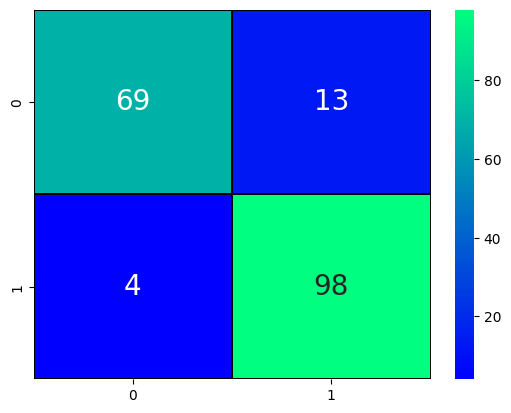

In [49]:
# Plot the confusion matrix
sns.heatmap(dl_cm, annot=True, cmap='winter', linewidths=0.3, linecolor='black', annot_kws={"size": 20})